# Masked Autoregressive Flows (MAFs)

In [41]:
%load_ext autoreload

%autoreload 2

import os
import logging

logging.getLogger('absl').setLevel(logging.ERROR)

#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.33"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import sbibm
import matplotlib.pyplot as plt
from functools import partial
from importlib import reload
from typing import Sequence, Callable, Any

from chainconsumer import ChainConsumer

import torch
import torch.utils.data as data

from jaxili.utils import create_data_loader
from jaxili.train import TrainerModule, TrainState

jax.config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Testing Masked Linear layer

In [2]:
from jaxili.model import MaskedLinear

model = MaskedLinear(3)
input = jnp.arange(5)
mask = jnp.zeros((5, 3))
model.initialize_mask(mask)

params = model.init(jax.random.PRNGKey(0), input)

In [3]:
model.apply(params, input) #The mask is initialized at 0

Array([0., 0., 0.], dtype=float64)

In [4]:
mask = jnp.ones((5, 3))
model.initialize_mask(mask)
print(mask)

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [5]:
model.apply(params, input) #The mask is full of one. You can check that you get the same result than with a dense layer.

Array([0.00597387, 0.04301045, 0.05765226], dtype=float64)

In [6]:
from jaxili.model import ConditionalMADE

In [7]:
model = ConditionalMADE(3, [5, 5], n_cond=3, gaussian=True, random_order=True, seed=42, activation='silu')

In [8]:
params = model.init(jax.random.PRNGKey(0), jnp.zeros(3), jnp.zeros(3))

In [9]:
input = jnp.array([0.5, 0.5, 0.5])
cond = jnp.array([1, 1, 1])
result = model.apply(params, input, cond) 

In [10]:
result

Array([ 0.00000000e+00,  2.84210168e-06, -7.61840414e-08,  0.00000000e+00,
        3.31383106e-07, -1.39609278e-06], dtype=float64)

### Testing MAF Layer

In [11]:
from jaxili.model import MAFLayer

In [12]:
maf_layer = MAFLayer(3, 3, [5, 5], reverse=False, seed=100, activation='silu')

In [13]:
params = maf_layer.init(jax.random.PRNGKey(0), jnp.zeros(3), jnp.zeros(3))

In [14]:
input = jnp.arange(3)
cond = jnp.zeros(3)

maf_layer.apply(params, input, cond)

Array([ 0.00000000e+00,  0.00000000e+00, -7.05953108e-08,  0.00000000e+00,
        0.00000000e+00, -6.89375821e-08], dtype=float64)

In [15]:
u, log_det = maf_layer.apply(params, input, cond, method="forward")
u, log_det

(Array([0., 1., 2.], dtype=float64), Array(-3.44687911e-08, dtype=float64))

In [16]:
maf_layer.apply(params, u.reshape(1, 3), cond.reshape(1, 3), method="backward") #We check that the MAFLayer is indeedinvertible.

(Array([[0., 1., 2.]], dtype=float64), Array([3.44687911e-08], dtype=float64))

### Testing MAF

In [17]:
from jaxili.model import ConditionalMAF

In [18]:
maf = ConditionalMAF(3, 3, 2, [128, 128], use_reverse=False, seed=42, activation='silu')

In [19]:
input = jnp.arange(9).reshape((3,3))
cond = jnp.zeros((3,3))
train = True
variables  = maf.init(jax.random.PRNGKey(0), input, cond, train=True)

In [20]:
u, log_det = maf.apply(variables, input, cond)
u, log_det

(Array([[0.        , 1.        , 1.99999834],
        [3.        , 3.999822  , 5.00056427],
        [6.        , 6.99937629, 8.00176257]], dtype=float64),
 Array([-1.12805548e-06,  6.01358198e-05,  1.20513785e-04], dtype=float64))

In [21]:
maf.apply(variables, u, cond, method='backward') #Same here, the transformation is invertible.

(Array([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]], dtype=float64),
 Array([ 1.12805548e-06, -6.01358198e-05, -1.20513785e-04], dtype=float64))

## Simulation model

In [22]:
sbibm.get_available_tasks()

['gaussian_mixture',
 'bernoulli_glm',
 'gaussian_linear',
 'gaussian_linear_uniform',
 'slcp',
 'two_moons',
 'sir',
 'lotka_volterra',
 'slcp_distractors',
 'bernoulli_glm_raw']

In [23]:
task = sbibm.get_task('slcp')
prior = task.get_prior()
simulator = task.get_simulator()
reference_samples = jnp.array(task.get_reference_posterior_samples(num_observation=1))
observation = jnp.array(task.get_observation(num_observation=1))
truth = jnp.array(task.get_true_parameters(num_observation=1).flatten())

dim = truth.shape[0]
dim_cond = observation.shape[1]

print(dim, dim_cond)

5 8


In [24]:
class SimulationDataset(data.Dataset):
    def __init__(self, simulator, prior, num_samples):
        super().__init__()
        self.thetas = prior(num_samples=num_samples)
        self.xs = simulator(self.thetas)
        self.thetas, self.xs = np.array(self.thetas, dtype=np.float64), np.array(self.xs, np.float64)

    def __len__(self):
        return len(self.thetas)
    
    def __getitem__(self, index):
        return self.thetas[index], self.xs[index]

In [25]:
train_set = SimulationDataset(simulator, prior, 20000)
val_set = SimulationDataset(simulator, prior, 2000)
test_set = SimulationDataset(simulator, prior, 5000)

train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train = [True, False, False],
    batch_size=128
)

## Neural posterior estimation using MAFs

In [26]:
from jaxili.model import ConditionalMAF

In [27]:
class MAFTrainer(TrainerModule):
    def __init__(self,
                 n_in : int,
                 n_cond : int,
                 n_layers : int,
                 layers : list[int],
                 use_reverse : bool,
                 seed : int = 42,
                 activation : str = 'silu',
                 trial : Any = None,
                 **kwargs
                 ):
        super().__init__(model_class=ConditionalMAF,
                         model_hparams={
                             'n_in': n_in,
                             'n_cond': n_cond,
                             'n_layers': n_layers,
                             'layers': layers,
                             'use_reverse': use_reverse,
                             'seed': seed,
                             'activation': activation
                         },
                         
                         **kwargs)
        self.trial = trial
        
    def create_functions(self):
        def loss_nll(params, batch, train):
            thetas, xs = batch
            output, updates = self.model.apply(
                {'params': params},
                  thetas, xs, train,
                  mutable=['batch_stats'], method='log_prob')
            return -jnp.mean(output), (output)
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch, train=True)
            (loss, (updates)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            #print(loss)
            state = state.apply_gradients(grads=grads)
            #state = state.replace(batch_stats=updates['batch_stats'])
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss, _ = loss_nll(state.params, batch, train=False)
            return {'loss': loss}
        
        return train_step, eval_step
        
    def print_tabulate(self, exmp_input):
        pass


In [38]:
CHECKPOINT_PATH = '~/Documents/jaxili/notebooks/checkpoints'

trainer = MAFTrainer(
    n_in=dim,
    n_cond=dim_cond,
    n_layers=5,
    layers=[50, 50],
    activation='relu',
    optimizer_hparams={'lr': 5e-3,
                       'optimizer_name': 'adam',
                       },
    logger_params={'base_log_dir': CHECKPOINT_PATH},
    exmp_input=next(iter(train_loader)),
    check_val_every_epoch=1,
    debug=False,
    use_reverse=True,
    seed=2
)

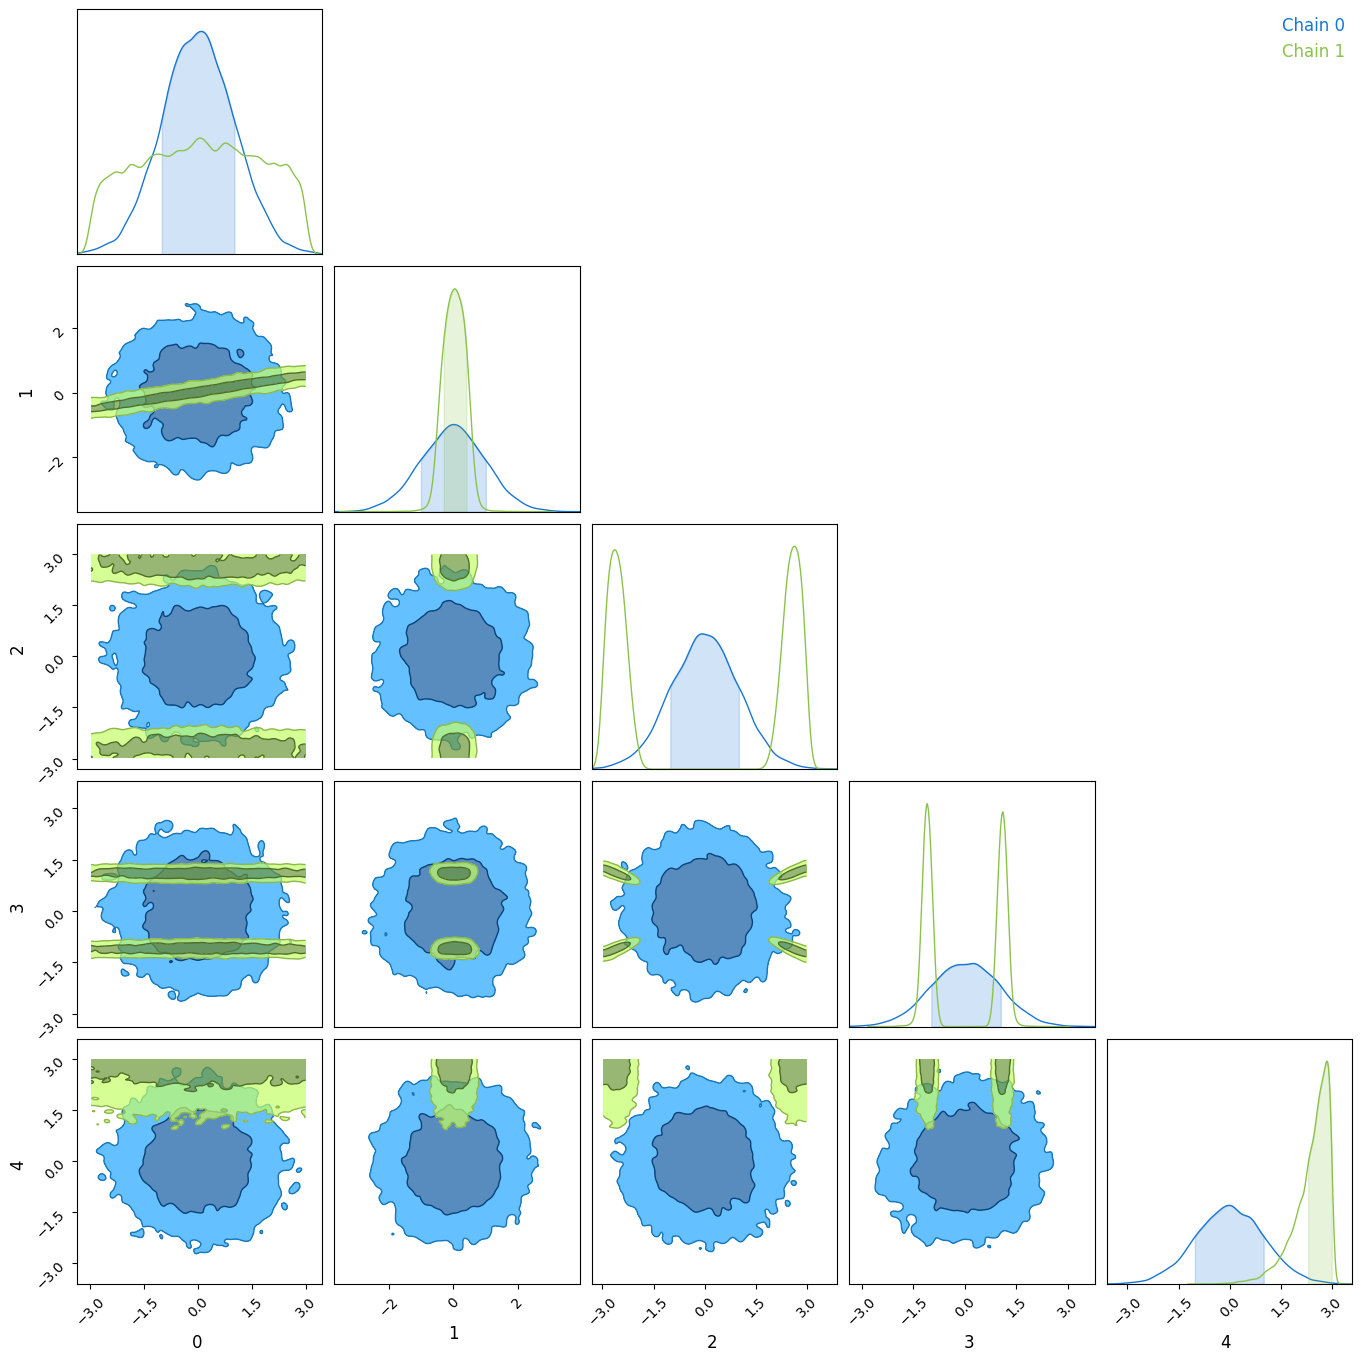

In [39]:
key = jax.random.PRNGKey(0)
samples = trainer.model.apply(
    {'params': trainer.state.params}, observation, num_samples=10000, key=key, method='sample'
)

c=ChainConsumer()
c.add_chain(samples)
c.add_chain(reference_samples)
fig = c.plotter.plot(figsize=2.)
plt.show()

In [42]:
metrics = trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=200
)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training:   0%|          | 0/156 [00:00<?, ?it/s]

/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Neural network training stopped after 178 epochs.
Early stopping with best validation metric: 3.7829397806369496
Best model saved at epoch 174
Early stopping parameters: min_delta=0.001, patience=20


In [43]:
print(f'Training loss: {metrics["train/loss"]}')
print(f'Validation loss: {metrics["val/loss"]}')
print(f'Test loss: {metrics["test/loss"]}')

Training loss: 3.0572936149584273
Validation loss: 3.782417324733708
Test loss: 3.9993471964851945


In [44]:
model = trainer.bind_model()

In [45]:
key = jax.random.PRNGKey(1)

samples = model.apply({'params': trainer.state.params}, observation, num_samples=10000, key=key, method='sample')

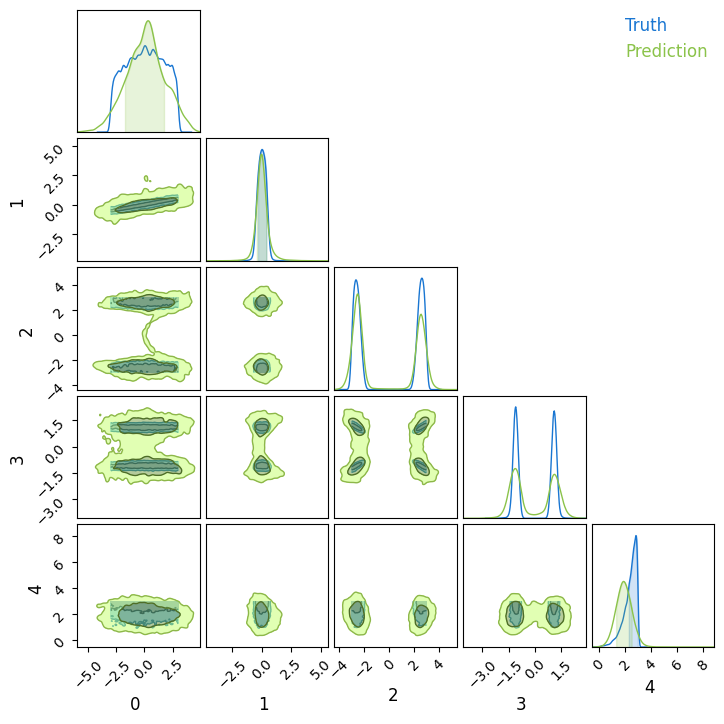

In [46]:
c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha = 0.5, name='Truth')
c.add_chain(samples, shade_alpha = 0.5, name="Prediction")
fig = c.plotter.plot(figsize=1.)
plt.show()

In [73]:
samples_image, _ = model.apply({'params': trainer.state.params}, reference_samples, observation*jnp.ones((10000, 1)), train=False)

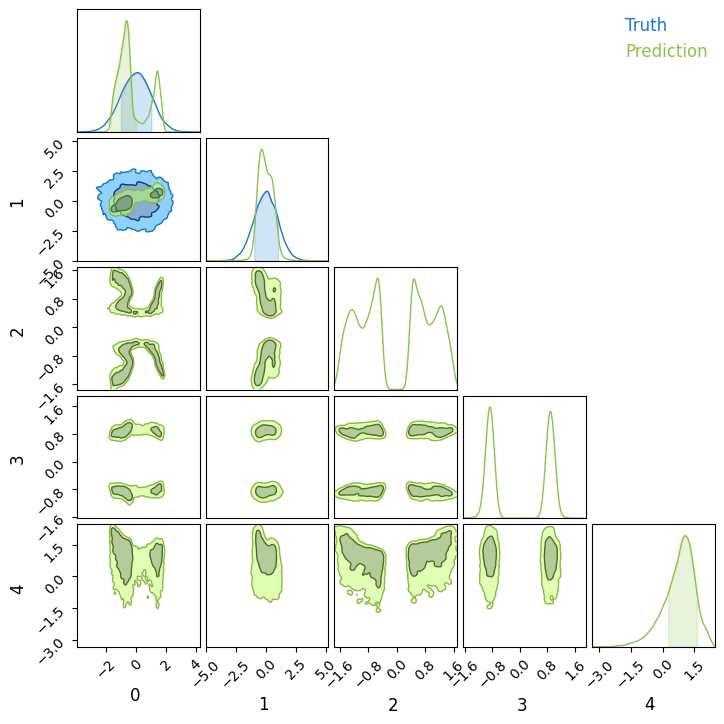

In [74]:
c = ChainConsumer()
c.add_chain(jax.random.multivariate_normal(key, jnp.zeros(2), jnp.eye(2), (10000,)), shade_alpha = 0.5, name='Truth')
c.add_chain(samples_image, shade_alpha = 0.5, name="Prediction")
fig = c.plotter.plot(figsize=1.)
plt.show()

In [50]:
%load_ext tensorboard
%tensorboard --logdir ~/work/jax/notebooks/checkpoints/

## Optimizing hyperparameter choice with Optuna

In [411]:
import optuna

In [412]:
CHECKPOINT_PATH = '/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints'

In [413]:
def objective(trial):
    my_train_loader, my_val_loader = create_data_loader(train_set, val_set,
                                                         train=[True, False],
                                                         batch_size=256)
    trainer = MAFTrainer(n_in=dim, #Create your trainer
                         n_cond=dim_cond,
                            n_layers=trial.suggest_int('n_layers', 3, 8),
                            layers=[50, 50],
                            use_reverse=trial.suggest_categorical('use_reverse', [True, False]),
                            activation='silu',
                            optimizer_hparams={
                                  'lr': trial.suggest_float('lr', 5e-5, 1e-3, log=True)
                              },
                            logger_params={'base_log_dir': CHECKPOINT_PATH},
                            exmp_input=next(iter(my_train_loader)), #beware of the training input.
                            check_val_every_epoch=5,
                            enable_progress_bar=False,
                            trial=trial)
    metrics = trainer.train_model(my_train_loader,
                                  my_val_loader,
                                  num_epochs=200)
    del trainer
    del my_train_loader, my_val_loader
    return metrics['val/loss']

In [414]:
study = optuna.create_study(
    study_name='maf_slcp_hparam_search',
    storage=f'sqlite:///{CHECKPOINT_PATH}/maf_hparam_search.db',
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50),
    load_if_exists=True
)
study.optimize(objective, n_trials=25-len(study.trials), n_jobs=1)

[I 2024-02-16 14:41:47,042] Using an existing study with name 'maf_slcp_hparam_search' instead of creating a new one.
[I 2024-02-16 14:44:08,115] Trial 1 finished with value: -0.9388174258374758 and parameters: {'n_components': 8, 'use_reverse': False, 'lr': 0.0006011936463140675}. Best is trial 1 with value: -0.9388174258374758.
[I 2024-02-16 14:45:25,014] Trial 2 finished with value: -0.3490371674459184 and parameters: {'n_components': 4, 'use_reverse': False, 'lr': 5.213172707951554e-05}. Best is trial 1 with value: -0.9388174258374758.
[I 2024-02-16 14:46:44,145] Trial 3 finished with value: -2.2023986383743632 and parameters: {'n_components': 4, 'use_reverse': True, 'lr': 7.066392621556046e-05}. Best is trial 3 with value: -2.2023986383743632.
[I 2024-02-16 14:48:23,613] Trial 4 finished with value: -0.969292912941678 and parameters: {'n_components': 5, 'use_reverse': False, 'lr': 0.0009718808251550976}. Best is trial 3 with value: -2.2023986383743632.
[I 2024-02-16 14:50:32,882] 

In [415]:
trial = study.best_trial
print(f'Best Loss: {trial.value:.2f}')
print(f'Best hyperparameters:')
for key, value in trial.params.items():
    print(f' ->   {key}: {value}')

Best Loss: -3.43
Best hyperparameters:
 ->   n_components: 5
 ->   use_reverse: True
 ->   lr: 0.0009754003600421239


In [416]:
trainer = MAFTrainer.load_from_checkpoints(os.path.join(CHECKPOINT_PATH, 'ConditionalMAF/version_19/'),
                                               exmp_input=next(iter(train_loader)))
test_metrics = trainer.eval_model(test_loader)
print(f'Test accuracy: {test_metrics["loss"]:.2f}')

Test accuracy: -3.42


In [418]:
fig = optuna.visualization.plot_contour(study, params=['lr', 'n_components'])
fig.show()

In [419]:
model = trainer.bind_model()

In [420]:
key = jax.random.PRNGKey(0) #let's get our samples

samples = model.apply({'params': trainer.state.params}, observation, num_samples=10000, key=key, method='sample')

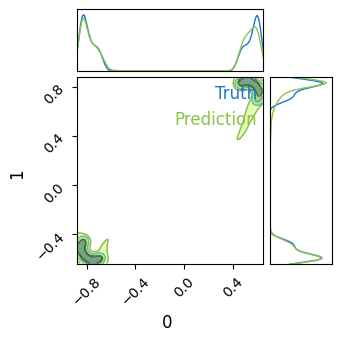

In [421]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_chain(reference_samples.squeeze(), shade_alpha = 0.5, name='Truth')
c.add_chain(samples, shade_alpha = 0.5, name="Prediction")
fig = c.plotter.plot(figsize=1.)
plt.show()